In [1]:
#imports
import sys
import subprocess 
import importlib

import time

import numpy as np

import scipy.constants as con
import scipy.optimize as opt
import scipy.linalg as la
from scipy import special
from scipy import integrate
from scipy.optimize import root_scalar
from scipy.integrate._ivp import common as jacpack
from scipy.interpolate import interp1d 

from numba import njit

#Nice plots
import matplotlib.pyplot as plt
import matplotlib.ticker as plticks
from mpl_toolkits.axes_grid1 import make_axes_locatable
width = 5.1
fontsize = 10
plt.rcParams.update({
    'text.usetex'        : True,
    'font.family'        : 'sans-serif',
    'font.size'          : fontsize,
    'text.latex.preamble': r'\usepackage{libertine}'
})
#plt.rcParams['text.latex.preamble'] = r'\usepackage{libertine}'
import re
from pylatexenc.latexencode import UnicodeToLatexEncoder, \
 UnicodeToLatexConversionRule, RULE_REGEX
u2latex = UnicodeToLatexEncoder(
    conversion_rules=[
        UnicodeToLatexConversionRule(rule_type=RULE_REGEX, rule=[
            (re.compile(r'𝜈'), r'\\ensuremath{\\nu}'),
            (re.compile(r'𝛾'), r'\\ensuremath{\\gamma}'),
            (re.compile(r'⁻'), r'\\ensuremath{^-}'),
            (re.compile(r'⁺'), r'\\ensuremath{^+}'),
        ]),
        'defaults'
    ]
)
#class for adding units to axis
class AddK(plticks.LogFormatterSciNotation):
    def __call__(self, x, pos=None):
        x = plticks.LogFormatterSciNotation.__call__(self, x,pos)
        s = x+' K'
        return s
    
class AddMeV(plticks.LogFormatterSciNotation):
    def __call__(self, x, pos=None):
        x = plticks.LogFormatterSciNotation.__call__(self, x,pos)
        s = x+' MeV'
        return s

#Reaction networks
import pynucastro as pyna
reaclibrary = pyna.ReacLibLibrary()
import np_AoT_net as bbn_np
#import AoT_net as bbn_Li
import bbn_test_integrate as bbn_Li
#import full_AoT_net as bbn_full
import full_size_net as bbn_full
networks=[bbn_np,bbn_Li,bbn_full]
importlib.reload(bbn_full)
#number of nuclei in network, nNucs[-1]=2 to since initial condition sets n and p
nNucs=[net.nnuc if isinstance(net.nnuc, int) else net.nnuc() for net in networks]+[2]

In [2]:
#Unit conversions
timeunit =1.519*10**21  #MeV/hbar in unit of 1/second 
TMeV2T9=11.60451812 #conversion factor from MeV to 10^9K
cm3s=1.167*10**-11  #conversion factor for cm^3/s
gcm3=232012         #conversion factor for g/cm^3
molcm3=216117376    #conversion factor for mol/cm^3 (cm^3*MeV^3)/(hbar^3*c^3*Avagadro number)
meter=5.068e12      #conversion factor for m
cm=5.068e10         #conversion factor for cm
barn=389.4          #conversion factor for barn
e_mass=0.51099895   #electron mass in MeV

#constants
n_life=879.6*timeunit   #Neutron lifetime in units of MeV/hbar
Q=1.293                 #neutron proton mass difference in MeV
M_u=931.494102          #atomic mass unit in MeV
SBC=np.pi**2/60         #Stefan-Boltzmann constant in natural units
G=6.709e-45             #gravatational constant in units of c=hbar=MeV=1
n_nu=3.046              #number of neutrino families with correction from 
                        #Nollett and Steigman, BBN and the CMB constrain neutrino coupled light WIMPs, 2015


#Setup isotopes based on Alterbbn
Y_labels=['n','p','H2','H3','He3','He4','Li6','Li7','Li8','Be7','Be9','B8','B10','B11','B12','C11','C12','C13','C14','N12','N13','N14','N15','O14','O15','O16']
Alter_Yl=["n","p","H2","H3","He3","He4","Li6","Li7","Be7","Li8","B8","Be9","B10","B11","C11","B12","C12","N12","C13","N13","C14","N14","O14","N15","O15","O16"]

fnNucs=nNucs[-2]

A=np.array([1,1,2,3,3,4,6,7,8,7,9,8,10,11,12,11,12,13,14,12,13,14,15,14,15,16])
Alter_A=[1.,1.,2.,3.,3.,4.,6.,7.,7.,8.,8.,9.,10.,11.,11.,12.,12.,12.,13.,13.,14.,14.,14.,15.,15.,16.]

Z=sorted([0,1,1,1,2,2,3,3,4,3,5,4,5,5,6,5,6,7,6,7,6,7,8,7,8,8])
Alter_Z=[0.,1.,1.,1.,2.,2.,3.,3.,4.,3.,5.,4.,5.,5.,6.,5.,6.,7.,6.,7.,6.,7.,8.,7.,8.,8.]

def Altersort(L):
    if type(L)==list:
        return [x for (a,x) in sorted(zip(zip(A,Z),L), key=lambda pair: pair[0])]
    else:
        return np.array([x for (a,x) in sorted(zip(zip(A,Z),L), key=lambda pair: pair[0])])

def PNAsort(L):
    if type(L)==list:
        return [x for (a,x) in sorted(zip(zip(Alter_Z,Alter_A),L), key=lambda pair: pair[0])]
    else:
        return np.array([x for (a,x) in sorted(zip(zip(Alter_Z,Alter_A),L), key=lambda pair: pair[0])])    


Alterspin=[0.5,0.5,1.,0.5,0.5,0.,1.,1.5,1.5,2.,2.,1.5,3.,1.5,1.5,1.,0.,1.,0.5,0.5,0.,1.,0.,0.5,0.5,0.]
spin=PNAsort(Alterspin)

Alter_mass_excess=[8.071388,7.289028,13.135825,14.949915,14.931325,2.424931,14.0864,14.9078,15.7696,20.9464,22.9212,11.34758,12.05086,8.6680,10.6506,13.3690,0.,17.3382,3.125036,5.3455,3.019916,2.863440,8.006521,0.101439,2.8554,-4.737036]
Alter_mass=[Alter_A[i]*M_u+Alter_mass_excess[i] for i in range(fnNucs)]
m_Nucs = np.array(PNAsort(Alter_mass))
m_n,m_p,m_d,m_t,m_He3,m_He4=m_Nucs[:6]

B=[(m_Nucs[1]*Z[i]+m_Nucs[0]*(A[i]-Z[i]))-m_Nucs[i] for i in range(fnNucs)]
g = 1+2*np.array(spin)

In [3]:
#Background
#Special functions og deres afledte
def L(z):
    return special.kn(2,z)/z

def M(z):
    return (3/4*special.kn(3,z)+1/4*special.kn(1,z))/z

def dMdz(z):
    return -3/z**2*special.kn(3,z) -special.kn(2,z)/z

def N(z):
    return (1/2*special.kn(4,z)+1/2*special.kn(2,z))/z

def rho_gamma(T):   #photon energy density
    return (np.pi**2)/15*T**4 

def drho_gamma(T):  #derivative
    return 4*(np.pi**2)/15*T**3 

def P_gamma(T):     #photon pressure
    return rho_gamma(T)/3

    

def rho_e(T): #electron/positron density, chemical potential assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,40)])

def drho_e(T): #derivative of rho_e with respect to temperature
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n)*n*z/T*dMdz(n*z) for n in range(1,40)])

def P_e(T): #electron/positron pressure
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)/(n*z)*L(n*z) for n in range(1,40)])  

### Initial conditions ###
t_max=1769922*timeunit
T_ini=10                     #initial temperature in MeV
t_ini=3/(2*np.sqrt(43/5*G*np.pi**3))/T_ini**2 #initial time in hbar/MeV
n_gamma_ini= 1.20206*2/np.pi**2*T_ini**3    #initial number density of photons based on theory
n_gamma_ini= rho_gamma(T_ini)/(2.701178*T_ini) #initial number density of photons based mean photon energy
eta=6.1e-10     #CMB baryon-to-photon ratio
eta_ini=eta*(1+(rho_e(T_ini)+P_e(T_ini))/(rho_gamma(T_ini)+P_gamma(T_ini))) #entropi bevarelse
rho_nu_ini=n_nu*7/8*(np.pi**2)/15*T_ini**4 #initial neutrino density
n_b_ini=eta_ini*n_gamma_ini    #initial baryon number density
rho_b_ini=m_p*n_b_ini           #initial baryon density

def rho_nu(a): #neutrino energy density
    return rho_nu_ini/a**4

def rho_b(a):
    return rho_b_ini/a**3


### Solving the background ###

def rho_tot(T,a): #total density
    return rho_e(T)+rho_gamma(T)+rho_nu(a)+rho_b(a)

def rho_set(T,a): #total density of non-decoupled components
    return rho_e(T)+rho_gamma(T)+rho_b(a)

def H(T,a):   #Hubble parameter as given by Friedmann eq, ignoring cosmological constant
    return np.sqrt(8*np.pi/3*G*rho_tot(T,a))

#Derivative from Kavano D.18
def dTdt(t,T,a):
    return -3*H(T,a)/((drho_e(T)+drho_gamma(T))/(rho_set(T,a) + P_e(T)+P_gamma(T)))

#Derivative from how H is defined
def dadt(t,T,a):
    return a*H(T,a)

#combining derivatives
def dbackground(t,y):   #solve h and T, y[0] = T, y[1] = a
    return [dTdt(t,*y),dadt(t,*y)]

t_range=[t_ini,t_max]            #time range for integration
#t_space=np.linspace(*t_range,1000)      #time range for approximate temperature


# Solving it
sol10 = integrate.solve_ivp(dbackground, t_range, [T_ini,1],method='RK45',atol=1e-80,rtol=1e-8,t_eval=np.geomspace(*t_range,200000))#,t_eval=t_space)

Tsqr10=sol10.y[0]**-2
asqrt10=sol10.y[1]**2
solt10=sol10.t

@njit
def T10_cache(t):   #solve h and T, y[0] = T, y[1] = a
    return 1/np.sqrt(np.interp(t,solt10,Tsqr10))
    #return -np.interp(t,sol.t,-sol.y[0])
    #return -interp1d(sol.t,-sol.y[0], kind='linear', copy=True, bounds_error=True, assume_sorted=True)(t)

@njit
def a10_cache(t):
    return np.sqrt(np.interp(t,solt10,asqrt10))
    #return np.interp(t,sol.t,sol.y[1])
    #return interp1d(sol.t,sol.y[1], kind='linear', copy=True, bounds_error=True, assume_sorted=True)(t)


#n_b_ini=eta*(1.20206*2/np.pi**2*T_cache(t_range[1])**3)*a_cache( t_range[1])**3



n_b_ini10=eta*(1.20206*2/np.pi**2*T10_cache(t_range[1])**3)*a10_cache( t_range[1])**3
    




In [4]:
t_test=176*timeunit


n_b_ini10/(eta*(1.20206*2/np.pi**2*T10_cache(t_test)**3)*a10_cache( t_test)**3)
#eta*(1+(rho_e(T_test)+P_e(T_test))/(rho_gamma(T_test)+P_gamma(T_test)))

1.1176674855899256

In [5]:
#Background
#Special functions og deres afledte
def L(z):
    return special.kn(2,z)/z

def M(z):
    return (3/4*special.kn(3,z)+1/4*special.kn(1,z))/z

def dMdz(z):
    return -3/z**2*special.kn(3,z) -special.kn(2,z)/z

def N(z):
    return (1/2*special.kn(4,z)+1/2*special.kn(2,z))/z

def rho_gamma(T):   #photon energy density
    return (np.pi**2)/15*T**4 

def drho_gamma(T):  #derivative
    return 4*(np.pi**2)/15*T**3 

def P_gamma(T):     #photon pressure
    return rho_gamma(T)/3

    

def rho_e(T): #electron/positron density, chemical potential assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,40)])

def drho_e(T): #derivative of rho_e with respect to temperature
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n)*n*z/T*dMdz(n*z) for n in range(1,40)])

def P_e(T): #electron/positron pressure
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)/(n*z)*L(n*z) for n in range(1,40)])  

### Initial conditions ###
t_max=1769922*timeunit
T_ini=100                     #initial temperature in MeV
t_ini=3/(2*np.sqrt(43/5*G*np.pi**3))/T_ini**2 #initial time in hbar/MeV
n_gamma_ini= 1.20206*2/np.pi**2*T_ini**3    #initial number density of photons based on theory
n_gamma_ini= rho_gamma(T_ini)/(2.701178*T_ini) #initial number density of photons based mean photon energy
eta=6.1e-10     #CMB baryon-to-photon ratio
eta_ini=eta*(1+(rho_e(T_ini)+P_e(T_ini))/(rho_gamma(T_ini)+P_gamma(T_ini))) #entropi bevarelse
rho_nu_ini=n_nu*7/8*(np.pi**2)/15*T_ini**4 #initial neutrino density
n_b_ini110=eta_ini*n_gamma_ini    #initial baryon number density
rho_b_ini=m_p*n_b_ini110           #initial baryon density

def rho_nu(a): #neutrino energy density
    return rho_nu_ini/a**4#*1.007

def rho_b(a):
    return 0#rho_b_ini/a**3


### Solving the background ###

def rho_tot(T,a): #total density
    return rho_e(T)+rho_gamma(T)+rho_nu(a)+rho_b(a)

def rho_set(T,a): #total density of non-decoupled components
    return rho_e(T)+rho_gamma(T)+rho_b(a)

def H(T,a):   #Hubble parameter as given by Friedmann eq, ignoring cosmological constant
    return np.sqrt(8*np.pi/3*G*rho_tot(T,a))

#Derivative from Kavano D.18
def dTdt(t,T,a):
    return -3*H(T,a)/((drho_e(T)+drho_gamma(T))/(rho_set(T,a) + P_e(T)+P_gamma(T)))

#Derivative from how H is defined
def dadt(t,T,a):
    return a*H(T,a)

#combining derivatives
def dbackground(t,y):   #solve h and T, y[0] = T, y[1] = a
    return [dTdt(t,*y),dadt(t,*y)]

t_range=[t_ini,t_max]            #time range for integration
#t_space=np.linspace(*t_range,1000)      #time range for approximate temperature


# Solving it
sol110 = integrate.solve_ivp(dbackground, t_range, [T_ini,1],method='RK45',atol=1e-80,rtol=1e-8,t_eval=np.geomspace(*t_range,2000000))#,t_eval=t_space)

Tsqr110=sol110.y[0]**-2
asqrt110=sol110.y[1]**2
solt110=sol110.t

@njit
def T110_cache(t):   #solve h and T, y[0] = T, y[1] = a
    return 1/np.sqrt(np.interp(t,solt110,Tsqr110))
    #return -np.interp(t,sol.t,-sol.y[0])
    #return -interp1d(sol.t,-sol.y[0], kind='linear', copy=True, bounds_error=True, assume_sorted=True)(t)

@njit
def a110_cache(t):
    return np.sqrt(np.interp(t,solt110,asqrt110))
    #return np.interp(t,sol.t,sol.y[1])
    #return interp1d(sol.t,sol.y[1], kind='linear', copy=True, bounds_error=True, assume_sorted=True)(t)


#n_b_ini=eta*(1.20206*2/np.pi**2*T_cache(t_range[1])**3)*a_cache( t_range[1])**3



#n_b_ini110=eta*(1.20206*2/np.pi**2*T110_cache(t_range[1])**3)*a110_cache( t_range[1])**3
    




In [6]:
#Background
#Special functions og deres afledte
def L(z):
    return special.kn(2,z)/z

def M(z):
    return (3/4*special.kn(3,z)+1/4*special.kn(1,z))/z

def dMdz(z):
    return -3/z**2*special.kn(3,z) -special.kn(2,z)/z

def N(z):
    return (1/2*special.kn(4,z)+1/2*special.kn(2,z))/z

def rho_gamma(T):   #photon energy density
    return (np.pi**2)/15*T**4 

def drho_gamma(T):  #derivative
    return 4*(np.pi**2)/15*T**3 

def P_gamma(T):     #photon pressure
    return rho_gamma(T)/3

    

def rho_e(T): #electron/positron density, chemical potential assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,40)])

def drho_e(T): #derivative of rho_e with respect to temperature
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n)*n*z/T*dMdz(n*z) for n in range(1,40)])

def P_e(T): #electron/positron pressure
    z=e_mass/T
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)/(n*z)*L(n*z) for n in range(1,40)])  

### Initial conditions ###
t_max=1769922*timeunit
T_ini=27/TMeV2T9                     #initial temperature in MeV
t_ini=3/(2*np.sqrt(43/5*G*np.pi**3))/T_ini**2 #initial time in hbar/MeV
n_gamma_ini= 1.20206*2/np.pi**2*T_ini**3    #initial number density of photons based on theory
n_gamma_ini= rho_gamma(T_ini)/(2.701178*T_ini) #initial number density of photons based mean photon energy
eta=6.1e-10     #CMB baryon-to-photon ratio
eta_ini=eta*(1+(rho_e(T_ini)+P_e(T_ini))/(rho_gamma(T_ini)+P_gamma(T_ini))) #entropi bevarelse
rho_nu_ini=n_nu*7/8*(np.pi**2)/15*T_ini**4 #initial neutrino density
n_b_ini=eta_ini*n_gamma_ini    #initial baryon number density
rho_b_ini=m_p*n_b_ini           #initial baryon density

def rho_nu(a): #neutrino energy density
    return rho_nu_ini/a**4#+0.0075/(1+0.8*T**2)*rho_nu_ini/a**4

def rho_b(T,a):
    return 0#rho_b_ini/a**3#+3/2*T*n_b_ini/a**3

#T**3/(T_ini**3*11/4)=1/a**3

def drho_b(T,a):
    return 0#3*rho_b_ini*T**2/(T_ini**3*11/4)

def P_b(T,a):
    return 0#T*n_b_ini/a**3

### Solving the background ###

def rho_tot(T,a): #total density
    return rho_e(T)+rho_gamma(T)+rho_nu(a)+rho_b(T,a)

def rho_set(T,a): #total density of non-decoupled components
    return rho_e(T)+rho_gamma(T)+rho_b(T,a)

def H(T,a):   #Hubble parameter as given by Friedmann eq, ignoring cosmological constant
    return np.sqrt(8*np.pi/3*G*rho_tot(T,a))

#Derivative from Kavano D.18
def dTdt(t,T,a):
    return -3*H(T,a)/((drho_e(T)+drho_gamma(T)+drho_b(T,a))/(rho_set(T,a) + P_b(T,a)+P_e(T)+P_gamma(T)))

#Derivative from how H is defined
def dadt(t,T,a):
    return a*H(T,a)

#combining derivatives
def dbackground(t,y):   #solve h and T, y[0] = T, y[1] = a
    return [dTdt(t,*y),dadt(t,*y)]

t_range=[t_ini,t_max]            #time range for integration
#t_space=np.linspace(*t_range,1000)      #time range for approximate temperature


# Solving it
sol = integrate.solve_ivp(dbackground, t_range, [T_ini,1],method='RK45',atol=1e-80,rtol=1e-8,t_eval=np.geomspace(*t_range,2000000))#,t_eval=t_space)

Tsqr=sol.y[0]**-2
asqrt=sol.y[1]**2
solt=sol.t

@njit
def T_cache(t):   #solve h and T, y[0] = T, y[1] = a
    return 1/np.sqrt(np.interp(t,solt,Tsqr))
    #return -np.interp(t,sol.t,-sol.y[0])
    #return -interp1d(sol.t,-sol.y[0], kind='linear', copy=True, bounds_error=True, assume_sorted=True)(t)

@njit
def a_cache(t):
    return np.sqrt(np.interp(t,solt,asqrt))
    #return np.interp(t,sol.t,sol.y[1])
    #return interp1d(sol.t,sol.y[1], kind='linear', copy=True, bounds_error=True, assume_sorted=True)(t)


#n_b_ini=eta*(1.20206*2/np.pi**2*T_cache(1e4*timeunit)**3)*a_cache(1e4*timeunit)**3


#n_b_ini=eta*(1.20206*2/np.pi**2*T_cache(t_range[1])**3)*a_cache( t_range[1])**3
    




In [7]:
#Functions for determining additional abundances for each network

#Initial conditions from thermal equilibrium
def get_Y_thermal(Y,n,T):
    Y_2 = np.zeros(n)
    Y_2[:len(Y)] = Y
    if T>0.5:#set to zero if out of equilibrium (3 seconds or 0.5MeV)
        for i in range(len(Y),n):
            tmp = special.zeta(3)**(A[i] - 1)*np.pi**((1 - A[i])/2)*2**((3*A[i] - 5)/2)*A[i]**(5/2)
            Y_2[i] = g[i]*tmp*(T/m_n)**(3*(A[i] - 1)/2)*eta_ini**(A[i] - 1)*Y[1]**Z[i]*Y[0]**(A[i] - Z[i])*np.exp(B[i]/T)/A[i]
    return Y_2

def solve_using_svd(U, s, Vh, b):
    bb = U.T @ b
    y = bb/s
    x = Vh.T @ y
    return x

#Initial conditions from Jacobian
def get_Y_jac(y,i):

    #if y[0]<0.1
    #    return 
    AdYdt_cut=lambda Y : Altersort(networks[i].rhs(1.1, PNAsort(Y) ,n_b_ini/y[1]**3*molcm3, y[0]*TMeV2T9*1e9))
    AdYdt_jac_cut=lambda Y : networks[i].jacobian(1.1, PNAsort(Y) ,n_b_ini/y[1]**3*molcm3, y[0]*TMeV2T9*1e9)[:, Altersort(range(nNucs[i]))][Altersort(range(nNucs[i]))]
    aY_cut=Altersort(get_Y_thermal(y[2:][:nNucs[i-1]],nNucs[i],y[0]))

    Yj = np.array([YY for YY in aY_cut])
    
    
    for cut in range(nNucs[i-1], len(Yj) - 2, 1):
        for j in range(10):
            fyj = -AdYdt_cut(Yj)
            jac = AdYdt_jac_cut(Yj)
            if np.any(np.isnan(Yj)) or np.any(np.isinf(Yj)):
                print('Yj:', Yj)
                raise ValueError
            if np.any(np.isnan(fyj)) or np.any(np.isinf(fyj)):
                print('Yj:', Yj)
                print('fyj:', fyj)
                raise ValueError
            # Implement cut:
            fyj = fyj[cut:]
            jac = jac[cut:, cut:]
            
            # Solution using SVD
            U, s, Vh = la.svd(jac)    
            x = solve_using_svd(U, s, Vh, fyj)
            for k in range(1):
                #A · δx = A · (x + δx) − b
                residuals = jac @ x - fyj
                dx = solve_using_svd(U, s, Vh, residuals)
                x -= dx
            Yj[cut:] += x
    return list(PNAsort(Yj))

In [8]:
3/(2*np.sqrt(36/5*G*np.pi**3))/T_ini**2

2.264112484957389e+20

In [9]:
#Load precise nudec data
Nudec=np.loadtxt('./nudec_BSM-master/Results/SM/SM_Thermo.dat',skiprows=0)



In [10]:
Nudec[:,5]

array([5.1101224e-02, 5.1574087e-02, 5.2051327e-02, 5.2532983e-02,
       5.3019096e-02, 5.3509708e-02, 5.4004861e-02, 5.4504596e-02,
       5.5008957e-02, 5.5517985e-02, 5.6031724e-02, 5.6550218e-02,
       5.7073511e-02, 5.7601646e-02, 5.8134670e-02, 5.8672627e-02,
       5.9215562e-02, 5.9763523e-02, 6.0316555e-02, 6.0874706e-02,
       6.1438023e-02, 6.2006553e-02, 6.2580345e-02, 6.3159448e-02,
       6.3743912e-02, 6.4333784e-02, 6.4929117e-02, 6.5529959e-02,
       6.6136363e-02, 6.6748380e-02, 6.7366061e-02, 6.7989460e-02,
       6.8618629e-02, 6.9253622e-02, 6.9894492e-02, 7.0541295e-02,
       7.1194084e-02, 7.1852916e-02, 7.2517846e-02, 7.3188931e-02,
       7.4549795e-02, 7.5239690e-02, 7.5935971e-02, 7.6638697e-02,
       7.7347928e-02, 7.8063725e-02, 7.8786148e-02, 7.9515258e-02,
       8.0251119e-02, 8.0993791e-02, 8.1743339e-02, 8.2499826e-02,
       8.3263317e-02, 8.4033875e-02, 8.4811568e-02, 8.5596460e-02,
       8.6388619e-02, 8.7188113e-02, 8.7995008e-02, 8.8809374e

In [11]:
Nudec[:,1]

array([1.0000000e+01, 9.9083194e+00, 9.8174794e+00, 9.7274722e+00,
       9.6382902e+00, 9.5499259e+00, 9.4623716e+00, 9.3756201e+00,
       9.2896639e+00, 9.2044957e+00, 9.1201084e+00, 9.0364947e+00,
       8.9536477e+00, 8.8715601e+00, 8.7902252e+00, 8.7096359e+00,
       8.6297855e+00, 8.5506671e+00, 8.4722741e+00, 8.3945999e+00,
       8.3176377e+00, 8.2413812e+00, 8.1658237e+00, 8.0909590e+00,
       8.0167806e+00, 7.9432823e+00, 7.8704579e+00, 7.7983011e+00,
       7.7268059e+00, 7.6559661e+00, 7.5857758e+00, 7.5162289e+00,
       7.4473197e+00, 7.3790423e+00, 7.3113908e+00, 7.2443596e+00,
       7.1779429e+00, 7.1121351e+00, 7.0469307e+00, 6.9823240e+00,
       6.8548823e+00, 6.7920363e+00, 6.7297666e+00, 6.6680677e+00,
       6.6069345e+00, 6.5463617e+00, 6.4863443e+00, 6.4268772e+00,
       6.3679552e+00, 6.3095734e+00, 6.2517269e+00, 6.1944108e+00,
       6.1376201e+00, 6.0813500e+00, 6.0255959e+00, 5.9703529e+00,
       5.9156163e+00, 5.8613816e+00, 5.8076442e+00, 5.7543994e

In [12]:
3/(2*np.sqrt(43/5*G*np.pi**3))/10**2/timeunit

0.007382960665019459

In [13]:
Nudec[0,0]

0.0073866869

In [14]:
NudecTsqr=Nudec[:,1]**-2
Nudecasqrt=Nudec[:,5]**2
Nudecsolt=Nudec[:,0]*timeunit

@njit
def NudecT_cache(t):   #solve h and T, y[0] = T, y[1] = a
    return 1/np.sqrt(np.interp(t,Nudecsolt,NudecTsqr))
    #return -np.interp(t,sol.t,-sol.y[0])
    #return -interp1d(sol.t,-sol.y[0], kind='linear', copy=True, bounds_error=True, assume_sorted=True)(t)

@njit
def Nudeca_cache(t):
    return np.sqrt(np.interp(t,Nudecsolt,Nudecasqrt))
    #return np.interp(t,sol.t,sol.y[1])
    #return interp1d(sol.t,sol.y[1], kind='linear', copy=True, bounds_error=True, assume_sorted=True)(t)


#n_b_ini=eta*(1.20206*2/np.pi**2*T_cache(t_range[1])**3)*a_cache( t_range[1])**3


Nudecn_b_ini=eta*(1.20206*2/np.pi**2*NudecT_cache(Nudecsolt[-1])**3)*Nudeca_cache(Nudecsolt[-1])**3
    

In [15]:
#Load precise Alterbbn data
data=np.loadtxt('./Alterdata/output.txt',skiprows=2)

'''
#run Alterbbn with chosen integration routine
failsafe=12
subprocess.run(["/home/hansbdein/Speciale/alterbbn_v2.2/no_err_calc.x", str(failsafe)], capture_output=True)
data=np.loadtxt('./output.txt',skiprows=2)
'''


#remove non-time steps
prevtime=0
mask=[]
for timestep in data:
    if timestep[0]>prevtime:
        prevtime=timestep[0]
        mask.append(True)
    else:
        mask.append(False)


data=data[mask,...]

print(data[0,0]/1e3)
#151983983107661.34
#1.519839831076613438e+14
#2.264733810941325e+20

#change Alterbbn data for time and temperature in hbar/GeV to hbar/MeV
data[:,0]*=1e-3
data[:,0]+=t_ini-data[0,0] #fix wrong start time
data[:,1]*=1e3
data[:,2]*=1e3
#change order of isotopes to be sorted by Y rather than A
data[:,3:]=PNAsort(data[:,3:].T).T
print(t_ini)
print(data[0,0])
nmaxindex=len([t for t in data[:,0] if t<t_max])

2.2641798198795177e+20
2.0716435021692168e+20
2.0716435021692168e+20


In [16]:
#(n_nu*7/8*(np.pi**2)/15)**(1/4)
data[-1,0]/timeunit

1769922.178095145

In [17]:
(11/4)**(1/3)

1.4010196653276936

In [18]:
(11/4)**(1/4)

1.2877547884506972

In [19]:
data[nmaxindex,1]/data[nmaxindex,2]

1.3980678207391175

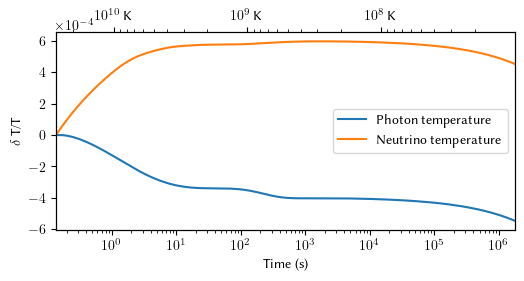

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(width, 2.65))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.095, right=0.995, bottom=0.155, top=0.9)

plt.plot(data[:nmaxindex,0]/timeunit,(data[:nmaxindex,1]-[T_cache(t) for t in data[:nmaxindex,0]])/[T_cache(t) for t in data[:nmaxindex,0]],label='Photon temperature')
plt.xscale('log')
plt.plot(data[:nmaxindex,0]/timeunit,(data[:nmaxindex,2]-T_ini/a_cache(data[:nmaxindex,0]))/(T_ini/a_cache(data[:nmaxindex,0])),label='Neutrino temperature')
plt.legend()

plt.xlabel('Time (s)')
plt.ylabel('$\delta$ T/T')
xlims=(data[0,0]/timeunit,data[nmaxindex,0]/timeunit)#data[0,0]/timeunit
#plt.ylim(1e-18,3)
plt.xlim(*xlims)
plt.xscale('log')

#plt.yticks([])
#plt.yticks(rotation=45)
#plt.yscale('log')
#plt.gca().yaxis.set_major_formatter(plticks.SciNotation())
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
#plt.legend(loc='center left')
plt.twiny()
plt.xscale('log')
plt.xlim(*(T_cache(timeunit*t)*TMeV2T9*1e9  for t in xlims))
plt.gca().xaxis.set_major_formatter(AddK())
#axes.ticklabel_format(axis= 'y' ,style='sci')
#fig.savefig('TeX/figures/comparetemp.pdf')

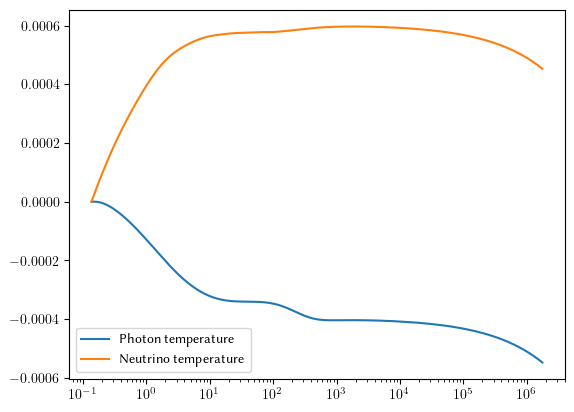

In [21]:
#rho_nu_ini=*T_ini**4


plt.plot(data[:nmaxindex,0]/timeunit,(data[:nmaxindex,1]-[T_cache(t) for t in data[:nmaxindex,0]])/data[:nmaxindex,1],label='Photon temperature')
plt.xscale('log')
plt.plot(data[:nmaxindex,0]/timeunit,(data[:nmaxindex,2]-T_ini/a_cache(data[:nmaxindex,0]))/data[:nmaxindex,2],label='Neutrino temperature')
plt.legend()

In [22]:
print(n_b_ini/((1.20206*2/np.pi**2*T_cache(1e5*timeunit)**3)*a_cache(1e5*timeunit)**3))
#T**3/(T_ini**3*11/4)=1/a**3

6.099983625325396e-10


(10000.0, 1769922.0)

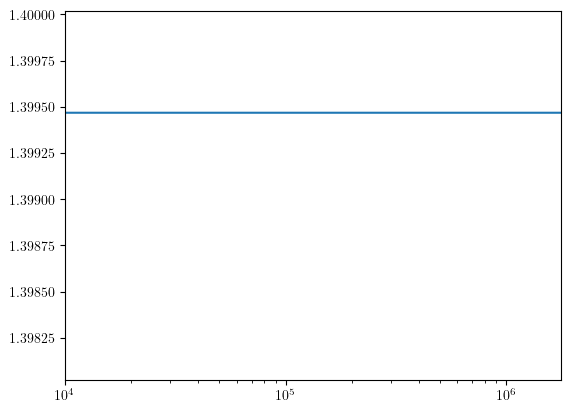

In [23]:
plt.plot(data[:nmaxindex,0]/timeunit,[T_cache(t) for t in data[:nmaxindex,0]]/np.array(T_ini/a_cache(data[:nmaxindex,0])),label='temperature ratio')
plt.xscale('log')
plt.ylim((11/4)**(1/3)-1e-3-0.2e-2,(11/4)**(1/3)+1e-3-0.2e-2)
plt.xlim(1e4,t_max/timeunit)

(10000.0, 1769922.0)

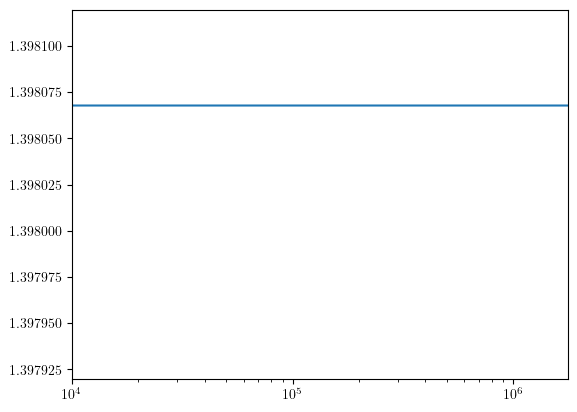

In [24]:
plt.plot(data[:nmaxindex,0]/timeunit,data[:nmaxindex,1]/data[:nmaxindex,2],label='temperature ratio')
plt.xscale('log')
plt.ylim((11/4)**(1/3)-1e-4-0.3e-2,(11/4)**(1/3)+1e-4-0.3e-2)
plt.xlim(1e4,t_max/timeunit)

In [25]:
a_cache(t_range[1])

3777.882388361345

(0.9999, 1.0001)

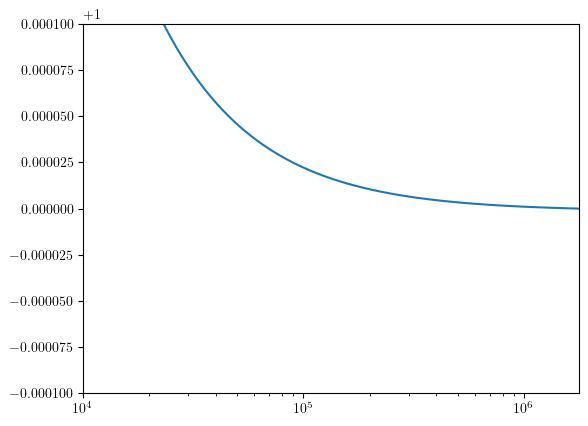

In [26]:
plt.plot(data[:nmaxindex,0]/timeunit,(T_ini/a_cache(data[:nmaxindex,0]))*np.sqrt(data[:nmaxindex,0])/((T_ini/a_cache(data[nmaxindex,0]))*np.sqrt(data[nmaxindex,0])),label='alterneutrino')
plt.xscale('log')
plt.xlim(1e4,t_max/timeunit)
plt.ylim(0.9999,1.0001)

(0.9999, 1.0001)

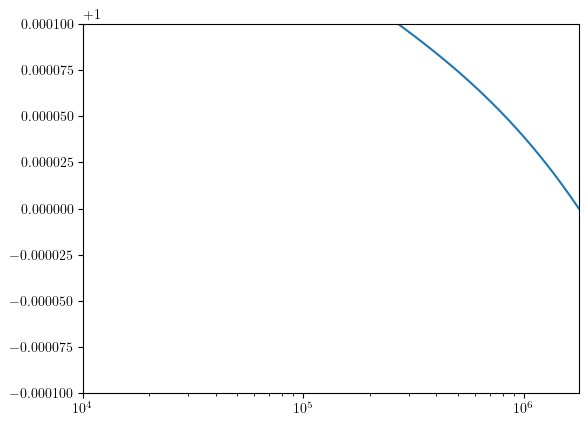

In [27]:
#rho_nu_ini=*T_ini**4


plt.plot(data[:nmaxindex,0]/timeunit,(data[:nmaxindex,2])*np.sqrt(data[:nmaxindex,0])/((data[nmaxindex,2])*np.sqrt(data[nmaxindex,0])),label='alterneutrino')
plt.xscale('log')
plt.xlim(1e4,t_max/timeunit)
plt.ylim(0.9999,1.0001)
#plt.plot(data[:nmaxindex,0]/timeunit,(data[:nmaxindex,2]-T_ini/Altera_cache(data[:nmaxindex,0]))/data[:nmaxindex,2],label='Neutrino temperature')
#plt.legend()

In [28]:
a10_cache(Nudecsolt)

array([1.00025326e+00, 1.00954306e+00, 1.01891852e+00, 1.02838045e+00,
       1.03792962e+00, 1.04756688e+00, 1.05729302e+00, 1.06710888e+00,
       1.07701528e+00, 1.08701307e+00, 1.09710311e+00, 1.10728624e+00,
       1.11756333e+00, 1.12793525e+00, 1.13840289e+00, 1.14896713e+00,
       1.15962887e+00, 1.17038903e+00, 1.18124849e+00, 1.19220814e+00,
       1.20326905e+00, 1.21443201e+00, 1.22569808e+00, 1.23706811e+00,
       1.24854319e+00, 1.26012417e+00, 1.27181211e+00, 1.28360801e+00,
       1.29551280e+00, 1.30752757e+00, 1.31965327e+00, 1.33189097e+00,
       1.34424175e+00, 1.35670658e+00, 1.36928656e+00, 1.38198274e+00,
       1.39479624e+00, 1.40772813e+00, 1.42077946e+00, 1.43395141e+00,
       1.46066157e+00, 1.47420200e+00, 1.48786762e+00, 1.50165946e+00,
       1.51557884e+00, 1.52962683e+00, 1.54380466e+00, 1.55811351e+00,
       1.57255463e+00, 1.58712929e+00, 1.60183863e+00, 1.61668394e+00,
       1.63166651e+00, 1.64678760e+00, 1.66204849e+00, 1.67745047e+00,
      

In [29]:
tcorr=3/(2*np.sqrt(43/5*G*np.pi**3))/10**2-Nudecsolt[0]

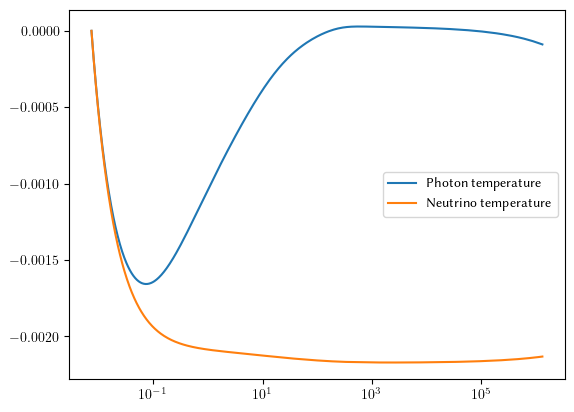

In [30]:
plt.plot(Nudecsolt/timeunit,(np.array([T10_cache(t+tcorr) for t in Nudecsolt])-[NudecT_cache(t) for t in Nudecsolt])/[NudecT_cache(t) for t in Nudecsolt],label='Photon temperature')
plt.xscale('log')
plt.plot(Nudecsolt/timeunit,(1/a10_cache(Nudecsolt+tcorr)-1/Nudec[:,5]*Nudec[0,5])/(1/Nudec[:,5]*Nudec[0,5]),label='Neutrino temperature')
#plt.ylim(-0.01,0.01)
plt.legend()

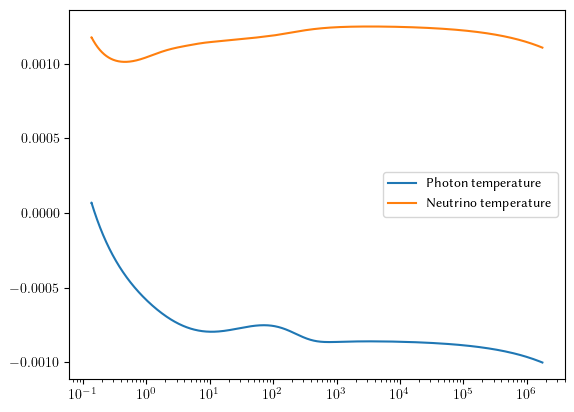

In [31]:
plt.plot(data[:nmaxindex,0]/timeunit,(data[:nmaxindex,1]-[T110_cache(t-3.418e17) for t in data[:nmaxindex,0]])/data[:nmaxindex,1],label='Photon temperature')
plt.xscale('log')
plt.plot(data[:nmaxindex,0]/timeunit,(data[:nmaxindex,2]-100/a110_cache(data[:nmaxindex,0]-3.418e17))/data[:nmaxindex,2],label='Neutrino temperature')

plt.legend()

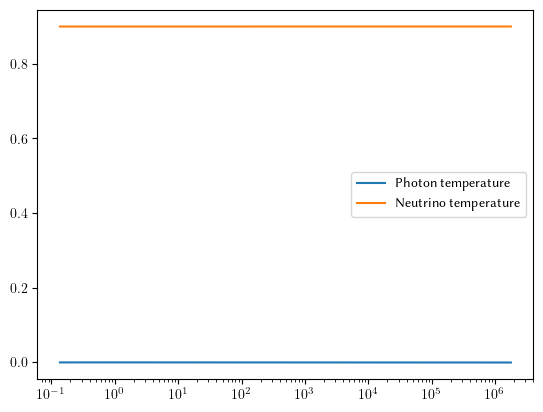

In [32]:
plt.plot(data[:nmaxindex,0]/timeunit,(data[:nmaxindex,1]-[T110_cache(t-6.778e17) for t in data[:nmaxindex,0]])/data[:nmaxindex,1],label='Photon temperature')
plt.xscale('log')
plt.plot(data[:nmaxindex,0]/timeunit,(data[:nmaxindex,2]-10/a110_cache(data[:nmaxindex,0]-6.778e17))/data[:nmaxindex,2],label='Neutrino temperature')

plt.legend()

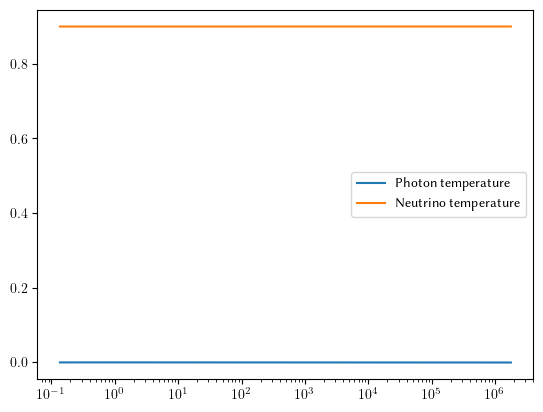

In [33]:
plt.plot(data[:nmaxindex,0]/timeunit,(data[:nmaxindex,1]-[T110_cache(t-6.778e17) for t in data[:nmaxindex,0]])/data[:nmaxindex,1],label='Photon temperature')
plt.xscale('log')
plt.plot(data[:nmaxindex,0]/timeunit,(data[:nmaxindex,2]-10/a110_cache(data[:nmaxindex,0]-6.778e17))/data[:nmaxindex,2],label='Neutrino temperature')

plt.legend()

In [34]:

alterTsqr=data[:,1]**-2
alterasqrt=(T_ini/data[:,2])**2


@njit
def AlterT_cache(t):   #solve h and T, y[0] = T, y[1] = a
    return 1/np.sqrt(np.interp(t,data[:,0],alterTsqr))
    #return -np.interp(t,sol.t,-sol.y[0])
    #return -interp1d(sol.t,-sol.y[0], kind='linear', copy=True, bounds_error=True, assume_sorted=True)(t)

@njit
def Altera_cache(t):
    return np.sqrt(np.interp(t,data[:,0],alterasqrt))
    #return np.interp(t,sol.t,sol.y[1])
    #return interp1d(sol.t,sol.y[1], kind='linear', copy=True, bounds_error=True, assume_sorted=True)(t)



In [35]:
#times for switching between networks
t_start=[0.09*timeunit,1*timeunit-6.778e17,100*timeunit-6.778e17,t_max-6.778e17]

#Solve the system
#initial conditions
#n_b_ini10=n_b_ini/(T_cache(t_max)*a_cache(t_max))**3*(T10_cache(t_max)*a10_cache(t_max))**3
solY110=np.array([[1/(np.exp(Q/T110_cache(t_start[0]))+1)],[1/(np.exp(-Q/T110_cache(t_start[0]))+1)]])
soltime110=np.array([t_start[0]])
evals110=0
for i in range(len(networks)):
    print(t_start[i]/timeunit)

    t_space=[point for point in data[:,0] if t_start[i]<=point<t_start[i+1]]
    t_space-=t_space[0]
    #ft_space=[point for point in data[:,0] if point>t_cut]

    initial_param=get_Y_jac(np.array([T110_cache(t_start[i]),a110_cache(t_start[i])]+list(solY110[:,-1])),i)
    #else:
    #    initial_param=list(solY[:,-1])+[0]*(nNucs[i]-nNucs[i-1])
    #Give PyNucAstro jacobian nessecary parameters
    def jac110PNA(t,Y):
        jac=networks[i].jacobian(t/timeunit, Y,n_b_ini110/a110_cache(t+t_start[i])**3*molcm3, T110_cache(t+t_start[i])*TMeV2T9*1e9)/timeunit
        return jac

    #full derivative
    def dydt110(t,Y): 
        result=networks[i].rhs(t/timeunit, Y,n_b_ini110/a110_cache(t+t_start[i])**3*molcm3, T110_cache(t+t_start[i])*TMeV2T9*1e9)/timeunit    
        return result
    
    jac110solY = integrate.solve_ivp(dydt110, [0,t_start[i+1]-t_start[i]], initial_param,method='Radau',atol=1e-80,rtol=1e-8,jac=jac110PNA)#,t_eval=t_space)#,first_step=timeunit*1e-3)#,)

    evals110+=jac110solY.nfev
    abun110=[abun[-1] for abun in jac110solY.y]
    
    solY110=np.concatenate((np.concatenate((solY110,np.full((nNucs[i]-nNucs[i-1],len(solY110[0])), np.nan, order='C'))),jac110solY.y),axis=1)

    soltime110=np.concatenate((soltime110,jac110solY.t+t_start[i]))

#interabuns.append(abun)
#interEvals.append(evals)
#solYs.append(solY)
#soltimes.append(soltime)
#print(jacsolY)

0.09
0.9995537853851217
99.99955378538513


In [36]:
#times for switching between networks
t_start=[t_ini,1*timeunit,100*timeunit,t_max]

#Solve the system
#initial conditions
#n_b_ini10=n_b_ini/(T_cache(t_max)*a_cache(t_max))**3*(T10_cache(t_max)*a10_cache(t_max))**3
solY10=np.array([[1/(np.exp(Q/T10_cache(t_start[0]))+1)],[1/(np.exp(-Q/T10_cache(t_start[0]))+1)]])
soltime10=np.array([t_start[0]])
evals10=0
for i in range(len(networks)):
    print(t_start[i]/timeunit)

    t_space=[point for point in data[:,0] if t_start[i]<=point<t_start[i+1]]
    t_space-=t_space[0]
    #ft_space=[point for point in data[:,0] if point>t_cut]

    initial_param=get_Y_jac(np.array([T10_cache(t_start[i]),a10_cache(t_start[i])]+list(solY10[:,-1])),i)
    #else:
    #    initial_param=list(solY[:,-1])+[0]*(nNucs[i]-nNucs[i-1])
    #Give PyNucAstro jacobian nessecary parameters
    def jac10PNA(t,Y):
        jac=networks[i].jacobian(t/timeunit, Y,n_b_ini10/a10_cache(t+t_start[i])**3*molcm3, T10_cache(t+t_start[i])*TMeV2T9*1e9)/timeunit
        return jac

    #full derivative
    def dydt10(t,Y): 
        result=networks[i].rhs(t/timeunit, Y,n_b_ini10/a10_cache(t+t_start[i])**3*molcm3, T10_cache(t+t_start[i])*TMeV2T9*1e9)/timeunit    
        return result
    
    jac10solY = integrate.solve_ivp(dydt10, [0,t_start[i+1]-t_start[i]], initial_param,method='Radau',atol=1e-80,rtol=1e-8,jac=jac10PNA,t_eval=t_space)#,first_step=timeunit*1e-3)#,)

    evals10+=jac10solY.nfev
    abun10=[abun[-1] for abun in jac10solY.y]
    
    solY10=np.concatenate((np.concatenate((solY10,np.full((nNucs[i]-nNucs[i-1],len(solY10[0])), np.nan, order='C'))),jac10solY.y),axis=1)

    soltime10=np.concatenate((soltime10,jac10solY.t+t_start[i]))

#interabuns.append(abun)
#interEvals.append(evals)
#solYs.append(solY)
#soltimes.append(soltime)
#print(jacsolY)

0.13638206070896752
1.0
100.0


In [37]:
#times for switching between networks
t_start=[t_ini,1*timeunit,100*timeunit,t_max]

etatestt=t_max#1e4*timeunit
#Solve the system
#initial conditions
Altern_b_ini=n_b_ini/(T_cache(etatestt)*a_cache(etatestt))**3*(AlterT_cache(etatestt)*Altera_cache(etatestt))**3
AltersolY=np.array([[1/(np.exp(Q/AlterT_cache(t_start[0]))+1)],[1/(np.exp(-Q/AlterT_cache(t_start[0]))+1)]])
Altersoltime=np.array([t_start[0]])
Alterevals=0
for i in range(len(networks)):
    print(t_start[i]/timeunit)

    t_space=[point for point in data[:,0] if t_start[i]<=point<t_start[i+1]]
    t_space-=t_space[0]
    #ft_space=[point for point in data[:,0] if point>t_cut]

    initial_param=get_Y_jac(np.array([AlterT_cache(t_start[i]),Altera_cache(t_start[i])]+list(AltersolY[:,-1])),i)
    #else:
    #    initial_param=list(solY[:,-1])+[0]*(nNucs[i]-nNucs[i-1])
    #Give PyNucAstro jacobian nessecary parameters
    def AlterjacPNA(t,Y):
        jac=networks[i].jacobian(t/timeunit, Y,Altern_b_ini/Altera_cache(t+t_start[i])**3*molcm3, AlterT_cache(t+t_start[i])*TMeV2T9*1e9)/timeunit
        return jac

    #full derivative
    def Alterdydt(t,Y): 
        result=networks[i].rhs(t/timeunit, Y,Altern_b_ini/Altera_cache(t+t_start[i])**3*molcm3, AlterT_cache(t+t_start[i])*TMeV2T9*1e9)/timeunit    
        return result
    
    AlterjacsolY = integrate.solve_ivp(Alterdydt, [0,t_start[i+1]-t_start[i]], initial_param,method='Radau',atol=1e-80,rtol=1e-8,jac=AlterjacPNA,t_eval=t_space)#,first_step=timeunit*1e-3)#,)

    Alterevals+=AlterjacsolY.nfev
    Alterabun=[abun[-1] for abun in AlterjacsolY.y]
    
    AltersolY=np.concatenate((np.concatenate((AltersolY,np.full((nNucs[i]-nNucs[i-1],len(AltersolY[0])), np.nan, order='C'))),AlterjacsolY.y),axis=1)

    Altersoltime=np.concatenate((Altersoltime,AlterjacsolY.t+t_start[i]))

#interabuns.append(abun)
#interEvals.append(evals)
#solYs.append(solY)
#soltimes.append(soltime)
#print(jacsolY)

0.13638206070896752
1.0
100.0


In [38]:
#times for switching between networks
t_start=[t_ini,1*timeunit,100*timeunit,t_max]

#Solve the system
#initial conditions
Nudecn_b_ini=n_b_ini/(T_cache(t_max)*a_cache(t_max))**3*(NudecT_cache(t_max)*Nudeca_cache(t_max))**3
NudecsolY=np.array([[1/(np.exp(Q/NudecT_cache(t_start[0]))+1)],[1/(np.exp(-Q/NudecT_cache(t_start[0]))+1)]])
Nudecsoltime=np.array([t_start[0]])
Nudecevals=0
for i in range(len(networks)):
    print(t_start[i]/timeunit)

    t_space=[point for point in data[:,0] if t_start[i]<=point<t_start[i+1]]
    t_space-=t_space[0]
    #ft_space=[point for point in data[:,0] if point>t_cut]

    initial_param=get_Y_jac(np.array([NudecT_cache(t_start[i]),Nudeca_cache(t_start[i])]+list(NudecsolY[:,-1])),i)
    #else:
    #    initial_param=list(solY[:,-1])+[0]*(nNucs[i]-nNucs[i-1])
    #Give PyNucAstro jacobian nessecary parameters
    def NudecjacPNA(t,Y):
        jac=networks[i].jacobian(t/timeunit, Y,Nudecn_b_ini/Nudeca_cache(t+t_start[i])**3*molcm3, NudecT_cache(t+t_start[i])*TMeV2T9*1e9)/timeunit
        return jac

    #full derivative
    def Nudecdydt(t,Y): 
        result=networks[i].rhs(t/timeunit, Y,Nudecn_b_ini/Nudeca_cache(t+t_start[i])**3*molcm3, NudecT_cache(t+t_start[i])*TMeV2T9*1e9)/timeunit    
        return result
    
    NudecjacsolY = integrate.solve_ivp(Nudecdydt, [0,t_start[i+1]-t_start[i]], initial_param,method='Radau',atol=1e-80,rtol=1e-8,jac=NudecjacPNA,t_eval=t_space)#,first_step=timeunit*1e-3)#,)

    Nudecevals+=NudecjacsolY.nfev
    Nudecabun=[abun[-1] for abun in NudecjacsolY.y]
    
    NudecsolY=np.concatenate((np.concatenate((NudecsolY,np.full((nNucs[i]-nNucs[i-1],len(NudecsolY[0])), np.nan, order='C'))),NudecjacsolY.y),axis=1)

    Nudecsoltime=np.concatenate((Nudecsoltime,NudecjacsolY.t+t_start[i]))

#interabuns.append(abun)
#interEvals.append(evals)
#solYs.append(solY)
#soltimes.append(soltime)
#print(jacsolY)

0.13638206070896752
1.0
100.0


In [39]:
#times for switching between networks
t_start=[t_ini,1*timeunit,100*timeunit,t_max]

#Solve the system
#initial conditions

solY=np.array([[1/(np.exp(Q/T_cache(t_start[0]))+1)],[1/(np.exp(-Q/T_cache(t_start[0]))+1)]])
soltime=np.array([t_start[0]])
evals=0
for i in range(len(networks)):
    print(t_start[i]/timeunit)
    
    t_space=[point for point in data[:,0] if t_start[i]<=point<t_start[i+1]]
    t_space-=t_space[0]
    #ft_space=[point for point in data[:,0] if point>t_cut]

    initial_param=get_Y_jac(np.array([T_cache(t_start[i]),a_cache(t_start[i])]+list(solY[:,-1])),i)
    #if i==1:
    #    initial_param[0]+=4e-4
    #    initial_param[1]-=4e-4
    #else:
    #    initial_param=list(solY[:,-1])+[0]*(nNucs[i]-nNucs[i-1])
    #Give PyNucAstro jacobian nessecary parameters
    def jacPNA(t,Y):
        jac=networks[i].jacobian(t/timeunit, Y,n_b_ini/a_cache(t+t_start[i])**3*molcm3, T_cache(t+t_start[i])*TMeV2T9*1e9)/timeunit
        return jac

    #full derivative
    def dydt(t,Y): 
        result=networks[i].rhs(t/timeunit, Y,n_b_ini/a_cache(t+t_start[i])**3*molcm3, T_cache(t+t_start[i])*TMeV2T9*1e9)/timeunit    
        return result
    
    jacsolY = integrate.solve_ivp(dydt, [0,t_start[i+1]-t_start[i]], initial_param,method='Radau',atol=1e-80,rtol=1e-8,jac=jacPNA,t_eval=t_space)#,first_step=timeunit*1e-3)#,)

    evals+=jacsolY.nfev
    abun=[abun[-1] for abun in jacsolY.y]
    
    solY=np.concatenate((np.concatenate((solY,np.full((nNucs[i]-nNucs[i-1],len(solY[0])), np.nan, order='C'))),jacsolY.y),axis=1)

    soltime=np.concatenate((soltime,jacsolY.t+t_start[i]))

#interabuns.append(abun)
#interEvals.append(evals)
#solYs.append(solY)
#soltimes.append(soltime)
#print(jacsolY)

0.13638206070896752
1.0
100.0


In [40]:
# Plot the results    
#soltime=midsoltimes[50]
#solY=midsolYs[50]
'''

#plt.figure('abundance',figsize=(6.4, 8))
fig, axes = plt.subplots(1, 1, figsize=(width, 4))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.135, right=0.975, bottom=0.125, top=0.9)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors*=8
line=['-']*10+['--']*10+[':']*10+['-.']*10+['-']*10+['--']*10+[':']*10+['-.']*10


for i in range(10,fnNucs):
    plt.plot(soltime/timeunit, data[:nmaxindex+1,i+3],':',color='lightgray')
for i in range(10):
    plt.plot(soltime/timeunit, data[:nmaxindex+1,i+3],line[i], color=colors[i], label=Y_labels[i])
#plt.plot(soltime/timeunit, (data[:,22]-solY[19])/solY[19],'k--', label='Other')

#solY[0:1]
#for i in range(10):
#    plt.plot(soltime/timeunit, np.array([get_Y_jac(np.array([T_cache(soltime[i]),a_cache(soltime[i])]+[solY[0][i],solY[1][i]]),1) for i in range(len(soltime))])
#,'--', color=colors[i], label=Y_labels[i])


#A[i]*get_Y_jac(y,i)[i]

#plt.axvline(soltime[1150]/timeunit)
plt.xlabel('Time (s)')
plt.ylabel('abundance ratio')
xlims=(0.09,t_max/timeunit)
plt.ylim(1e-18,3)
plt.xlim(*xlims)
plt.xscale('log')
plt.yscale('log')#plt.yscale('symlog',linthresh=1.2e-3,linscale=0.5)

plt.legend(loc='center left')
plt.twiny()
plt.xscale('log')
plt.xlim(*(T_cache(timeunit*t)*TMeV2T9*1e9  for t in xlims))
plt.gca().xaxis.set_major_formatter(AddK())
#fig.savefig('TeX/figures/abundancelight.pdf')
plt.show()

####

fig, axes = plt.subplots(1, 1, figsize=(width, 5))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.135, right=0.975, bottom=0.1, top=0.93)

lateline=['-.','-',':','--']

#for i in range(10,fnNucs):
#    plt.plot(soltime/timeunit, A[i]*solY[i],lateline[(Z[i]-A[i])% 4], color=colors[A[i]-8], label=Y_labels[i])

for i in range(10,fnNucs):
    plt.plot(soltime/timeunit, (data[:nmaxindex+1,i+3]-solY[i])/solY[i],'-' if i==11 else lateline[A[i]% 4], color=colors[(i-11)//4], label=Y_labels[i])



#plt.plot(soltime/timeunit, A[10]*solY[10],'k:', label='Be9')
#for i in range(11,fnNucs):
#    plt.plot(soltime/timeunit, A[i]*solY[i],lateline[i], color=colors[i% 4], label=Y_labels[i])

  
#plt.axvline(soltime[1200]/timeunit)
plt.xlabel('Time (s)')
plt.ylabel('abundance ratio')
plt.ylim(-1,1)
xlims=(10,2e4)
plt.xlim(*xlims)
plt.xscale('log')
#plt.yscale('log')
plt.legend(loc='center left')
plt.twiny()
plt.xscale('log')
plt.xlim(*(T_cache(timeunit*t)*TMeV2T9*1e9 for t in xlims))
plt.gca().xaxis.set_major_formatter(AddK())

#fig.savefig('TeX/figures/abundanceheavy.pdf')
plt.show()
'''

"\n\n#plt.figure('abundance',figsize=(6.4, 8))\nfig, axes = plt.subplots(1, 1, figsize=(width, 4))\n\nfig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.135, right=0.975, bottom=0.125, top=0.9)\n\nprop_cycle = plt.rcParams['axes.prop_cycle']\ncolors = prop_cycle.by_key()['color']\ncolors*=8\nline=['-']*10+['--']*10+[':']*10+['-.']*10+['-']*10+['--']*10+[':']*10+['-.']*10\n\n\nfor i in range(10,fnNucs):\n    plt.plot(soltime/timeunit, data[:nmaxindex+1,i+3],':',color='lightgray')\nfor i in range(10):\n    plt.plot(soltime/timeunit, data[:nmaxindex+1,i+3],line[i], color=colors[i], label=Y_labels[i])\n#plt.plot(soltime/timeunit, (data[:,22]-solY[19])/solY[19],'k--', label='Other')\n\n#solY[0:1]\n#for i in range(10):\n#    plt.plot(soltime/timeunit, np.array([get_Y_jac(np.array([T_cache(soltime[i]),a_cache(soltime[i])]+[solY[0][i],solY[1][i]]),1) for i in range(len(soltime))])\n#,'--', color=colors[i], label=Y_labels[i])\n\n\n#A[i]*get_Y_jac(y,i)[i]\n\n#plt.axvline(soltime[1150]/timeunit)

In [41]:
# Plot the results    
#soltime=midsoltimes[50]
#solY=midsolYs[50]
'''

#plt.figure('abundance',figsize=(6.4, 8))
fig, axes = plt.subplots(1, 1, figsize=(width, 4))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.135, right=0.975, bottom=0.125, top=0.9)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors*=8
line=['-']*10+['--']*10+[':']*10+['-.']*10+['-']*10+['--']*10+[':']*10+['-.']*10


for i in range(10,fnNucs):
    plt.plot(Altersoltime/timeunit, (data[:nmaxindex+1,i+3]-AltersolY[i])/data[:nmaxindex+1,i+3],':',color='lightgray')
for i in range(10):
    plt.plot(Altersoltime/timeunit, (data[:nmaxindex+1,i+3]-AltersolY[i])/data[:nmaxindex+1,i+3],line[i], color=colors[i], label=Y_labels[i])
#plt.plot(soltime/timeunit, (data[:,22]-solY[19])/solY[19],'k--', label='Other')

#solY[0:1]
#for i in range(10):
#    plt.plot(soltime/timeunit, np.array([get_Y_jac(np.array([T_cache(soltime[i]),a_cache(soltime[i])]+[solY[0][i],solY[1][i]]),1) for i in range(len(soltime))])
#,'--', color=colors[i], label=Y_labels[i])


#A[i]*get_Y_jac(y,i)[i]

plt.axvline(data[23555,0]/timeunit)
plt.xlabel('Time (s)')
plt.ylabel('abundance ratio')
#xlims=(0.09,t_max/timeunit)
xlims=(20,2e4)
plt.ylim(-1,1)
plt.xlim(*xlims)
plt.xscale('log')
plt.yscale('symlog',linthresh=1.2e-3,linscale=0.5)

plt.legend(loc='center left')
plt.twiny()
plt.xscale('log')
plt.xlim(*(AlterT_cache(timeunit*t)*TMeV2T9*1e9  for t in xlims))
plt.gca().xaxis.set_major_formatter(AddK())
#fig.savefig('TeX/figures/abundancelight.pdf')
plt.show()

####

fig, axes = plt.subplots(1, 1, figsize=(width, 5))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.135, right=0.975, bottom=0.1, top=0.93)

lateline=['-.','-',':','--']

#for i in range(10,fnNucs):
#    plt.plot(soltime/timeunit, A[i]*solY[i],lateline[(Z[i]-A[i])% 4], color=colors[A[i]-8], label=Y_labels[i])

for i in range(10,fnNucs):
    plt.plot(Altersoltime/timeunit, (data[:nmaxindex+1,i+3]-AltersolY[i])/AltersolY[i],'-' if i==11 else lateline[A[i]% 4], color=colors[(i-11)//4], label=Y_labels[i])



#plt.plot(soltime/timeunit, A[10]*solY[10],'k:', label='Be9')
#for i in range(11,fnNucs):
#    plt.plot(soltime/timeunit, A[i]*solY[i],lateline[i], color=colors[i% 4], label=Y_labels[i])

  
#plt.axvline(soltime[1200]/timeunit)
plt.xlabel('Time (s)')
plt.ylabel('abundance ratio')
plt.ylim(-1,1)
xlims=(10,2e4)
plt.xlim(*xlims)
plt.xscale('log')
#plt.yscale('log')
plt.legend(loc='center left')
plt.twiny()
plt.xscale('log')
plt.xlim(*(T_cache(timeunit*t)*TMeV2T9*1e9 for t in xlims))
plt.gca().xaxis.set_major_formatter(AddK())

#fig.savefig('TeX/figures/abundanceheavy.pdf')
plt.show()
'''

"\n\n#plt.figure('abundance',figsize=(6.4, 8))\nfig, axes = plt.subplots(1, 1, figsize=(width, 4))\n\nfig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.135, right=0.975, bottom=0.125, top=0.9)\n\nprop_cycle = plt.rcParams['axes.prop_cycle']\ncolors = prop_cycle.by_key()['color']\ncolors*=8\nline=['-']*10+['--']*10+[':']*10+['-.']*10+['-']*10+['--']*10+[':']*10+['-.']*10\n\n\nfor i in range(10,fnNucs):\n    plt.plot(Altersoltime/timeunit, (data[:nmaxindex+1,i+3]-AltersolY[i])/data[:nmaxindex+1,i+3],':',color='lightgray')\nfor i in range(10):\n    plt.plot(Altersoltime/timeunit, (data[:nmaxindex+1,i+3]-AltersolY[i])/data[:nmaxindex+1,i+3],line[i], color=colors[i], label=Y_labels[i])\n#plt.plot(soltime/timeunit, (data[:,22]-solY[19])/solY[19],'k--', label='Other')\n\n#solY[0:1]\n#for i in range(10):\n#    plt.plot(soltime/timeunit, np.array([get_Y_jac(np.array([T_cache(soltime[i]),a_cache(soltime[i])]+[solY[0][i],solY[1][i]]),1) for i in range(len(soltime))])\n#,'--', color=colors[i], l

In [42]:
data[23555,1]*TMeV2T9

1.875087298096852

In [43]:
data[23555,0]/timeunit

37.47852845362

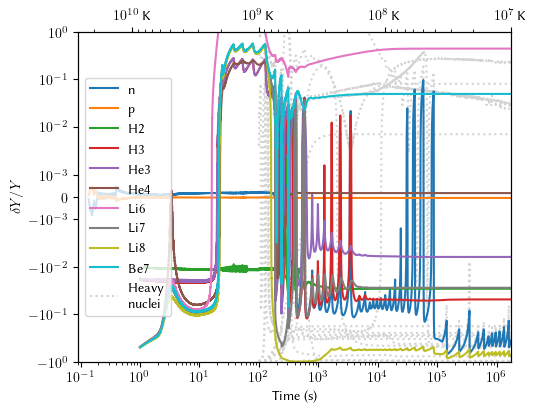

"\n####\n\nfig, axes = plt.subplots(1, 1, figsize=(width, 5))\n\nfig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.135, right=0.975, bottom=0.1, top=0.93)\n\nlateline=['-.','-',':','--']\n\n#for i in range(10,fnNucs):\n#    plt.plot(soltime/timeunit, A[i]*solY[i],lateline[(Z[i]-A[i])% 4], color=colors[A[i]-8], label=Y_labels[i])\n\nfor i in range(10,fnNucs):\n    plt.plot(Altersoltime/timeunit, (data[:nmaxindex+1,i+3]-AltersolY[i])/AltersolY[i],'-' if i==11 else lateline[A[i]% 4], color=colors[(i-11)//4], label=Y_labels[i])\n\n\n\n#plt.plot(soltime/timeunit, A[10]*solY[10],'k:', label='Be9')\n#for i in range(11,fnNucs):\n#    plt.plot(soltime/timeunit, A[i]*solY[i],lateline[i], color=colors[i% 4], label=Y_labels[i])\n\n  \n#plt.axvline(soltime[1200]/timeunit)\nplt.xlabel('Time (s)')\nplt.ylabel('abundance ratio')\nplt.ylim(-1,1)\nxlims=(10,2e4)\nplt.xlim(*xlims)\nplt.xscale('log')\n#plt.yscale('log')\nplt.legend(loc='center left')\nplt.twiny()\nplt.xscale('log')\nplt.xlim(*(T_cache(t

In [44]:
# Plot the results    
#soltime=midsoltimes[50]
#solY=midsolYs[50]


#plt.figure('abundance',figsize=(6.4, 8))
fig, axes = plt.subplots(1, 1, figsize=(width, 4))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.135, right=0.985, bottom=0.105, top=0.93)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors*=8
line=['-']*10+['--']*10+[':']*10+['-.']*10+['-']*10+['--']*10+[':']*10+['-.']*10
res=10

for i in range(10,fnNucs):
    plt.plot(Altersoltime[::res]/timeunit, (data[:nmaxindex+1,i+3][::res]-AltersolY[i][::res])/AltersolY[i][::res],':',color='lightgray')
for i in range(10):
    plt.plot(Altersoltime[::res]/timeunit, (data[:nmaxindex+1,i+3][::res]-AltersolY[i][::res])/AltersolY[i][::res],line[i], color=colors[i], label=Y_labels[i])
plt.plot(Altersoltime/timeunit, (AltersolY[19])/AltersolY[19]**2,':',color='lightgray', label='Heavy \n nuclei')

#solY[0:1]
#for i in range(10):
#    plt.plot(soltime/timeunit, np.array([get_Y_jac(np.array([T_cache(soltime[i]),a_cache(soltime[i])]+[solY[0][i],solY[1][i]]),1) for i in range(len(soltime))])
#,'--', color=colors[i], label=Y_labels[i])


#A[i]*get_Y_jac(y,i)[i]

#plt.axvline(soltime[1150]/timeunit)
plt.xlabel('Time (s)')
plt.ylabel(r'$\delta Y/Y$')
xlims=(0.09,t_max/timeunit)
plt.ylim(-1,1)
plt.xlim(*xlims)
plt.xscale('log')
plt.yscale('symlog',linthresh=1.2e-3,linscale=0.5)

plt.legend(loc='center left')
plt.twiny()
plt.xscale('log')
plt.xlim(*(AlterT_cache(timeunit*t)*TMeV2T9*1e9  for t in xlims))
plt.gca().xaxis.set_major_formatter(AddK())
#fig.savefig('TeX/figures/AlterratesBBNdeltaY.pdf')
plt.show()
'''
####

fig, axes = plt.subplots(1, 1, figsize=(width, 5))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.135, right=0.975, bottom=0.1, top=0.93)

lateline=['-.','-',':','--']

#for i in range(10,fnNucs):
#    plt.plot(soltime/timeunit, A[i]*solY[i],lateline[(Z[i]-A[i])% 4], color=colors[A[i]-8], label=Y_labels[i])

for i in range(10,fnNucs):
    plt.plot(Altersoltime/timeunit, (data[:nmaxindex+1,i+3]-AltersolY[i])/AltersolY[i],'-' if i==11 else lateline[A[i]% 4], color=colors[(i-11)//4], label=Y_labels[i])



#plt.plot(soltime/timeunit, A[10]*solY[10],'k:', label='Be9')
#for i in range(11,fnNucs):
#    plt.plot(soltime/timeunit, A[i]*solY[i],lateline[i], color=colors[i% 4], label=Y_labels[i])

  
#plt.axvline(soltime[1200]/timeunit)
plt.xlabel('Time (s)')
plt.ylabel('abundance ratio')
plt.ylim(-1,1)
xlims=(10,2e4)
plt.xlim(*xlims)
plt.xscale('log')
#plt.yscale('log')
plt.legend(loc='center left')
plt.twiny()
plt.xscale('log')
plt.xlim(*(T_cache(timeunit*t)*TMeV2T9*1e9 for t in xlims))
plt.gca().xaxis.set_major_formatter(AddK())

#fig.savefig('TeX/figures/abundanceheavy.pdf')
plt.show()
'''

In [45]:
# Plot the results    
#soltime=midsoltimes[50]
#solY=midsolYs[50]

'''
#plt.figure('abundance',figsize=(6.4, 8))
fig, axes = plt.subplots(1, 1, figsize=(width, 4))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.135, right=0.975, bottom=0.125, top=0.9)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors*=8
line=['-']*10+['--']*10+[':']*10+['-.']*10+['-']*10+['--']*10+[':']*10+['-.']*10


for i in range(10,fnNucs):
    plt.plot(soltime/timeunit, (solY[i]-AltersolY[i])/solY[i],':',color='lightgray')
for i in range(10):
    plt.plot(soltime/timeunit, (solY[i]-AltersolY[i])/solY[i],line[i], color=colors[i], label=Y_labels[i])
#plt.plot(soltime/timeunit, (data[:,22]-solY[19])/solY[19],'k--', label='Other')

#solY[0:1]
#for i in range(10):
#    plt.plot(soltime/timeunit, np.array([get_Y_jac(np.array([T_cache(soltime[i]),a_cache(soltime[i])]+[solY[0][i],solY[1][i]]),1) for i in range(len(soltime))])
#,'--', color=colors[i], label=Y_labels[i])


#A[i]*get_Y_jac(y,i)[i]

#plt.axvline(soltime[1150]/timeunit)
plt.xlabel('Time (s)')
plt.ylabel('abundance ratio')
xlims=(0.09,t_max/timeunit)
plt.ylim(-0.1,0.1)
plt.xlim(*xlims)
plt.xscale('log')
#plt.yscale('log')
plt.yscale('symlog',linthresh=1e-5,linscale=0.5)
plt.legend(loc='center left')
plt.twiny()
plt.xscale('log')
plt.xlim(*(T_cache(timeunit*t)*TMeV2T9*1e9  for t in xlims))
plt.gca().xaxis.set_major_formatter(AddK())
#fig.savefig('TeX/figures/abundancelight.pdf')
plt.show()

####

fig, axes = plt.subplots(1, 1, figsize=(width, 5))

fig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.135, right=0.975, bottom=0.1, top=0.93)

lateline=['-.','-',':','--']

#for i in range(10,fnNucs):
#    plt.plot(soltime/timeunit, A[i]*solY[i],lateline[(Z[i]-A[i])% 4], color=colors[A[i]-8], label=Y_labels[i])

for i in range(10,fnNucs):
    plt.plot(soltime/timeunit, (solY[i]-AltersolY[i])/solY[i],'-' if i==11 else lateline[A[i]% 4], color=colors[(i-11)//4], label=Y_labels[i])



#plt.plot(soltime/timeunit, A[10]*solY[10],'k:', label='Be9')
#for i in range(11,fnNucs):
#    plt.plot(soltime/timeunit, A[i]*solY[i],lateline[i], color=colors[i% 4], label=Y_labels[i])
plt.yscale('symlog',linthresh=1e-8,linscale=1e-5)
  
#plt.axvline(soltime[1200]/timeunit)
plt.xlabel('Time (s)')
plt.ylabel('abundance ratio')
plt.ylim(-0.1,0.1)
xlims=(10,2e4)
plt.xlim(*xlims)
plt.xscale('log')
#plt.yscale('log')
plt.legend(loc='center left')
plt.twiny()
plt.xscale('log')
plt.xlim(*(T_cache(timeunit*t)*TMeV2T9*1e9 for t in xlims))
plt.gca().xaxis.set_major_formatter(AddK())

#fig.savefig('TeX/figures/abundanceheavy.pdf')
plt.show()
'''

"\n#plt.figure('abundance',figsize=(6.4, 8))\nfig, axes = plt.subplots(1, 1, figsize=(width, 4))\n\nfig.subplots_adjust(wspace=0.2, hspace=0.05, left=0.135, right=0.975, bottom=0.125, top=0.9)\n\nprop_cycle = plt.rcParams['axes.prop_cycle']\ncolors = prop_cycle.by_key()['color']\ncolors*=8\nline=['-']*10+['--']*10+[':']*10+['-.']*10+['-']*10+['--']*10+[':']*10+['-.']*10\n\n\nfor i in range(10,fnNucs):\n    plt.plot(soltime/timeunit, (solY[i]-AltersolY[i])/solY[i],':',color='lightgray')\nfor i in range(10):\n    plt.plot(soltime/timeunit, (solY[i]-AltersolY[i])/solY[i],line[i], color=colors[i], label=Y_labels[i])\n#plt.plot(soltime/timeunit, (data[:,22]-solY[19])/solY[19],'k--', label='Other')\n\n#solY[0:1]\n#for i in range(10):\n#    plt.plot(soltime/timeunit, np.array([get_Y_jac(np.array([T_cache(soltime[i]),a_cache(soltime[i])]+[solY[0][i],solY[1][i]]),1) for i in range(len(soltime))])\n#,'--', color=colors[i], label=Y_labels[i])\n\n\n#A[i]*get_Y_jac(y,i)[i]\n\n#plt.axvline(soltime[1

In [46]:
rho_gamma(T_cache(300*timeunit))

1.2441331839739533e-05

In [47]:
rho_b_ini/a_cache(300*timeunit)**3

4.1412319833090434e-11

In [48]:
print('Results from this code with dumb correction')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H '+'\t\t Li6/H '+'\t\t Be7/H ')

print('value:\t '"{:.3e}".format(4*abun110[5])+'\t '+"{:.3e}".format(abun110[2]/abun110[1])+'\t '+"{:.3e}".format((abun110[3]+abun110[4])/abun110[1])+'\t '+"{:.3e}".format((abun110[7]+abun110[9])/abun110[1])+'\t '+"{:.3e}".format((abun110[6])/abun110[1])+'\t '+"{:.3e}".format((abun110[9])/abun110[1]))


Results from this code with dumb correction
	 Yp  		 H2/H 		 H3/H 		 Li7/H 		 Li6/H 		 Be7/H 
value:	 2.470e-01	 2.532e-05	 1.040e-05	 5.146e-10	 7.503e-15	 4.851e-10


In [49]:
print('Results from this code with dumb correction')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H '+'\t\t Li6/H '+'\t\t Be7/H ')

print('value:\t '"{:.3e}".format(4*abun110[5])+'\t '+"{:.3e}".format(abun110[2]/abun110[1])+'\t '+"{:.3e}".format((abun110[3]+abun110[4])/abun110[1])+'\t '+"{:.3e}".format((abun110[7]+abun110[9])/abun110[1])+'\t '+"{:.3e}".format((abun110[6])/abun110[1])+'\t '+"{:.3e}".format((abun110[9])/abun110[1]))


Results from this code with dumb correction
	 Yp  		 H2/H 		 H3/H 		 Li7/H 		 Li6/H 		 Be7/H 
value:	 2.470e-01	 2.532e-05	 1.040e-05	 5.146e-10	 7.503e-15	 4.851e-10


In [50]:
eta

6.1e-10

In [51]:
print('Results from this code with Nudec background')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H '+'\t\t Li6/H '+'\t\t Be7/H ')

print('value:\t '"{:.3e}".format(4*Nudecabun[5])+'\t '+"{:.3e}".format(Nudecabun[2]/Nudecabun[1])+'\t '+"{:.3e}".format((Nudecabun[3]+Nudecabun[4])/Nudecabun[1])+'\t '+"{:.3e}".format((Nudecabun[7]+Nudecabun[9])/abun[1])+'\t '+"{:.3e}".format((Nudecabun[6])/Nudecabun[1])+'\t '+"{:.3e}".format((Nudecabun[9])/Nudecabun[1]))



Results from this code with Nudec background
	 Yp  		 H2/H 		 H3/H 		 Li7/H 		 Li6/H 		 Be7/H 
value:	 2.469e-01	 2.532e-05	 1.040e-05	 5.146e-10	 7.498e-15	 4.848e-10


In [52]:
print('Results from this code with early neutrino decoupling')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H '+'\t\t Li6/H '+'\t\t Be7/H ')

print('value:\t '"{:.3e}".format(4*abun10[5])+'\t '+"{:.3e}".format(abun10[2]/abun10[1])+'\t '+"{:.3e}".format((abun10[3]+abun10[4])/abun10[1])+'\t '+"{:.3e}".format((abun10[7]+abun10[9])/abun10[1])+'\t '+"{:.3e}".format((abun10[6])/abun10[1])+'\t '+"{:.3e}".format((abun10[9])/abun10[1]))



Results from this code with early neutrino decoupling
	 Yp  		 H2/H 		 H3/H 		 Li7/H 		 Li6/H 		 Be7/H 
value:	 2.470e-01	 2.534e-05	 1.040e-05	 5.140e-10	 7.510e-15	 4.844e-10


In [53]:
print('Results from this code')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H '+'\t\t Li6/H '+'\t\t Be7/H ')

print('value:\t '"{:.3e}".format(4*abun[5])+'\t '+"{:.3e}".format(abun[2]/abun[1])+'\t '+"{:.3e}".format((abun[3]+abun[4])/abun[1])+'\t '+"{:.3e}".format((abun[7]+abun[9])/abun[1])+'\t '+"{:.3e}".format((abun[6])/abun[1])+'\t '+"{:.3e}".format((abun[9])/abun[1]))



Results from this code
	 Yp  		 H2/H 		 H3/H 		 Li7/H 		 Li6/H 		 Be7/H 
value:	 2.472e-01	 2.536e-05	 1.040e-05	 5.140e-10	 7.523e-15	 4.844e-10


In [54]:
print('Results from this code')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H '+'\t\t Li6/H '+'\t\t Be7/H ')

print('value:\t '"{:.3e}".format(4*abun[5])+'\t '+"{:.3e}".format(abun[2]/abun[1])+'\t '+"{:.3e}".format((abun[3]+abun[4])/abun[1])+'\t '+"{:.3e}".format((abun[7]+abun[9])/abun[1])+'\t '+"{:.3e}".format((abun[6])/abun[1])+'\t '+"{:.3e}".format((abun[9])/abun[1]))



Results from this code
	 Yp  		 H2/H 		 H3/H 		 Li7/H 		 Li6/H 		 Be7/H 
value:	 2.472e-01	 2.536e-05	 1.040e-05	 5.140e-10	 7.523e-15	 4.844e-10


In [55]:
print('Results from this code')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H '+'\t\t Li6/H '+'\t\t Be7/H ')

print('value:\t '"{:.3e}".format(4*abun[5])+'\t '+"{:.3e}".format(abun[2]/abun[1])+'\t '+"{:.3e}".format((abun[3]+abun[4])/abun[1])+'\t '+"{:.3e}".format((abun[7]+abun[9])/abun[1])+'\t '+"{:.3e}".format((abun[6])/abun[1])+'\t '+"{:.3e}".format((abun[9])/abun[1]))



Results from this code
	 Yp  		 H2/H 		 H3/H 		 Li7/H 		 Li6/H 		 Be7/H 
value:	 2.472e-01	 2.536e-05	 1.040e-05	 5.140e-10	 7.523e-15	 4.844e-10


In [56]:
print('compare')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H '+'\t\t Li6/H '+'\t\t Be7/H ')

print('value:\t '"{:.3e}".format(abun[5]/abun110[5]-1)+'\t '+"{:.3e}".format(abun[2]/abun110[2]-1)+'\t '+"{:.3e}".format((abun[3]+abun[4])/(abun110[3]+abun110[4])-1)+'\t '+"{:.3e}".format((abun[7]+abun[9])/(abun110[7]+abun110[9])-1)+'\t '+"{:.3e}".format((abun[6])/(abun110[6])-1)+'\t '+"{:.3e}".format((abun[9])/abun110[9]-1))



compare
	 Yp  		 H2/H 		 H3/H 		 Li7/H 		 Li6/H 		 Be7/H 
value:	 7.323e-04	 1.541e-03	 3.926e-04	 -1.466e-03	 2.504e-03	 -1.686e-03


In [57]:
print('value:\t '"{:.3e}".format(abun[5]/Alterabun[5]-1)+'\t '+"{:.3e}".format(abun[2]/Alterabun[2]-1)+'\t '+"{:.3e}".format((abun[3]+abun[4])/(Alterabun[3]+Alterabun[4])-1)+'\t '+"{:.3e}".format((abun[7]+abun[9])/(Alterabun[7]+Alterabun[9])-1)+'\t '+"{:.3e}".format((abun[6])/(Alterabun[6])-1)+'\t '+"{:.3e}".format((abun[9])/Alterabun[9]-1))


value:	 -4.967e-04	 -1.328e-03	 -3.641e-04	 1.343e-03	 -1.977e-03	 1.529e-03


In [58]:
[4.967e-04	, -1.328e-03,	 -3.641e-04	, 1.410e-03,	 -1.977e-03,	 1.619e-03]/np.array([7.323e-04	, 1.541e-03	, 3.926e-04	 ,-1.546e-03	, 2.504e-03	, -1.793e-03])

array([ 0.67827393, -0.86177807, -0.92740703, -0.91203105, -0.78953674,
       -0.90295594])

In [59]:
print('Results from this code with AlterBBN background and eta')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H '+'\t\t Li6/H '+'\t\t Be7/H ')

print('value:\t '"{:.3e}".format(4*Alterabun[5])+'\t '+"{:.3e}".format(Alterabun[2]/Alterabun[1])+'\t '+"{:.3e}".format((Alterabun[3]+Alterabun[4])/Alterabun[1])+'\t '+"{:.3e}".format((Alterabun[7]+Alterabun[9])/abun[1])+'\t '+"{:.3e}".format((Alterabun[6])/Alterabun[1])+'\t '+"{:.3e}".format((Alterabun[9])/Alterabun[1]))



Results from this code with AlterBBN background and eta
	 Yp  		 H2/H 		 H3/H 		 Li7/H 		 Li6/H 		 Be7/H 
value:	 2.473e-01	 2.540e-05	 1.041e-05	 5.133e-10	 7.539e-15	 4.837e-10


In [60]:
print('Results from this code with AlterBBN background and eta')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H '+'\t\t Li6/H '+'\t\t Be7/H ')

print('value:\t '"{:.3e}".format(4*Alterabun[5])+'\t '+"{:.3e}".format(Alterabun[2]/Alterabun[1])+'\t '+"{:.3e}".format((Alterabun[3]+Alterabun[4])/Alterabun[1])+'\t '+"{:.3e}".format((Alterabun[7]+Alterabun[9])/abun[1])+'\t '+"{:.3e}".format((Alterabun[6])/Alterabun[1])+'\t '+"{:.3e}".format((Alterabun[9])/Alterabun[1]))



Results from this code with AlterBBN background and eta
	 Yp  		 H2/H 		 H3/H 		 Li7/H 		 Li6/H 		 Be7/H 
value:	 2.473e-01	 2.540e-05	 1.041e-05	 5.133e-10	 7.539e-15	 4.837e-10


In [61]:
print(' ')
print('High precision Alterbbn results')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H '+'\t\t Li6/H '+'\t\t Be7/H ')
dataabun=data[-1,3:]
print('value:\t '"{:.3e}".format(4*dataabun[5])+'\t '+"{:.3e}".format(dataabun[2]/dataabun[1])+'\t '+"{:.3e}".format((dataabun[3]+dataabun[4])/dataabun[1])+'\t '+"{:.3e}".format((dataabun[7]+dataabun[9])/dataabun[1])+'\t '+"{:.3e}".format((dataabun[6])/dataabun[1])+'\t '+"{:.3e}".format((dataabun[9])/dataabun[1]))


 
High precision Alterbbn results
	 Yp  		 H2/H 		 H3/H 		 Li7/H 		 Li6/H 		 Be7/H 
value:	 2.474e-01	 2.467e-05	 1.034e-05	 5.363e-10	 1.087e-14	 5.075e-10


In [62]:
print('compare')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H '+'\t\t Li6/H '+'\t\t Be7/H ')

print('value:\t '"{:.3e}".format(abun[5]/dataabun[5]-1)+'\t '+"{:.3e}".format(abun[2]/dataabun[2]-1)+'\t '+"{:.3e}".format((abun[3]+abun[4])/(dataabun[3]+dataabun[4])-1)+'\t '+"{:.3e}".format((abun[7]+abun[9])/(dataabun[7]+dataabun[9])-1)+'\t '+"{:.3e}".format((abun[6])/(dataabun[6])-1)+'\t '+"{:.3e}".format((abun[9])/dataabun[9]-1))


compare
	 Yp  		 H2/H 		 H3/H 		 Li7/H 		 Li6/H 		 Be7/H 
value:	 -6.648e-04	 2.840e-02	 6.189e-03	 -4.142e-02	 -3.080e-01	 -4.529e-02


In [63]:
print(n_b_ini/((1.20206*2/np.pi**2*T_cache(t_range[1])**3)*a_cache(t_range[1])**3))


6.099983449689515e-10


In [64]:
n_b_ini/((1.20206*2/np.pi**2*T_cache(t_range[1])**3)*a_cache(t_range[1])**3)

6.099983449689515e-10

In [65]:
Altern_b_ini=n_b_ini/(T_cache(t_max)*a_cache(t_max))**3*(AlterT_cache(t_max)*Altera_cache(t_max))**3

In [66]:
print(Altern_b_ini/((1.20206*2/np.pi**2*AlterT_cache(t_range[1])**3)*Altera_cache(t_range[1])**3))


6.099983449689514e-10


In [67]:
nival=[-10.22, 61.24,-340.33, 1057.27,-2045.58, 2605.91,-2266.15, 1374.26,
-586.06, 174.87532902234145,-35.72, 4.75,-0.37, 0.013]

In [68]:
def NT(T):
    if e_mass/T<4:
        return sum([nival[i]*(e_mass/T)**(i+1) for i in range(13)])
    return 0

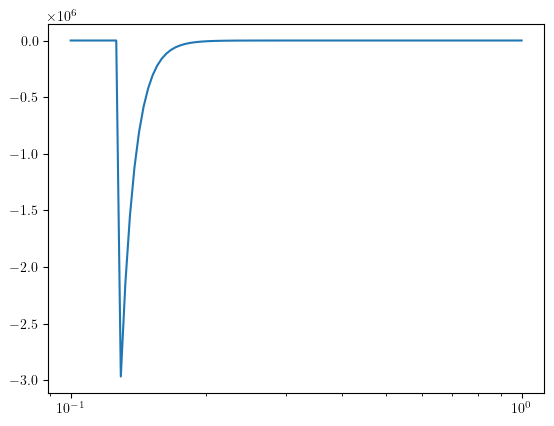

In [69]:

Tests2=np.geomspace(0.1,1,100)
plt.plot(Tests2,[NT(T) for T in Tests2])
plt.xscale('log')

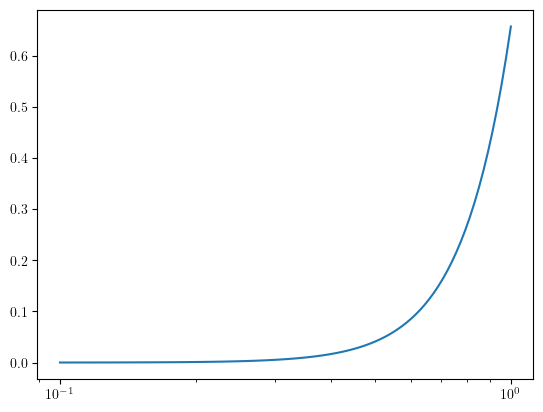

In [70]:

Tests2=np.geomspace(0.1,1,100)
plt.plot(Tests2,[rho_gamma(T) for T in Tests2])
plt.xscale('log')

In [71]:
np.exp(-0.2)

0.8187307530779818

(10, 0.03)

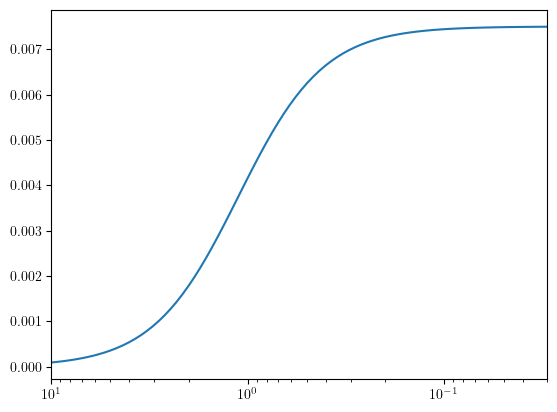

In [72]:
def testf(T):
    return 0.0075/(1+0.8*T**2)

Tests2=np.geomspace(10,0.01,100)

plt.plot(Tests2,[testf(T) for T in Tests2])
plt.xscale('log')
plt.xlim(10,0.03)

(10, 0.03)

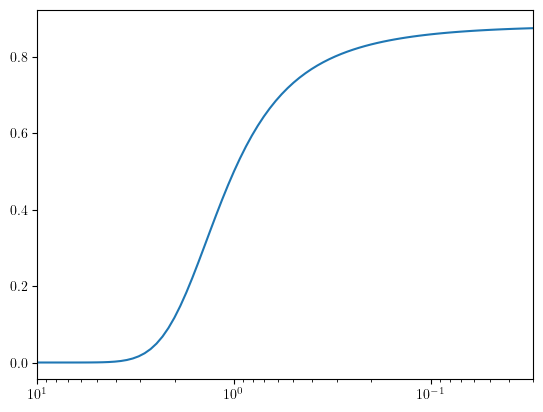

In [73]:
def testf(T):
    return 1/(1+np.exp(-2*(1-T)))

Tests2=np.geomspace(10,0.01,100)
plt.plot(Tests2,[testf(T) for T in Tests2])
plt.xscale('log')
plt.xlim(10,0.03)